In [25]:
import src.get_data as get_data
import src.load_data as load
import src.compute_income as ci
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

import keras.backend as K
from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 22


In [26]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model



In [27]:
def nextDayPrediction(typeBlockchain, stock, N = 1):    
    
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    df = get_data.get_data_frame(typeBlockchain, stock)
    df.index = df.date
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    all_df = df.copy()
    features = ['low', 'high']
    
    x = all_df[features].copy()
    
    y = all_df['close'].copy()
    
    #x = pd.ewma(x,2)
    #y = pd.ewma(y,2)
    
    NUM_FEATURES = x.shape[1]
    
    x[features] = x_scaler.fit_transform(x)

    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    x['close'] = y
    
    #X_train, y_train = load.load_data(x, WINDOW, TrainTest = False)
    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)
    x = x[features]
    model = build_model(input_shape=(WINDOW, NUM_FEATURES))
    
    print('START FIT MODEL...')
    
    start = time.time()
    
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=0,
              callbacks=[history])
    
    #model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=1)
    end = time.time()

    print ('Learning time: ', end-start)
    
    today = time.strftime("_%d_%m_%Y")
    
    pathModel = "../../models/model_low_high_RAW" + typeBlockchain + today +".h5"
    #pathModel = "../../models/model_low_high_USDT_BTC_03_08_2017.h5"
    save_model(model, pathModel)
    
    #model = load_model(pathModel)
    # one day prediction. get last batch known data (now we didnt need in y value and can predict it)  
    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

    # now we make dataframe and create row names in date

    lastDate =str(df.date[df.last_valid_index()]).split('-')
    currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
    predictionDate = pd.date_range(currentData, periods=1)
    prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)


    print (prediction)



    if plotForTrain:

        trainPredict = model.predict(X_train)
        trainPredict = y_scaler.inverse_transform(trainPredict)
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
        Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
        Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
        ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
        TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

        iplot([ActualValues,TrainingValues])
        plt.show()

    if plot:
        calc_income = all_df.close[-y_test.shape[0]:]
        
        trainPredict = model.predict(X_train)
        testPredict = model.predict(X_test)

        trainPredict = y_scaler.inverse_transform(trainPredict)
        trainY = y_scaler.inverse_transform([y_train])

        testPredict = y_scaler.inverse_transform(testPredict)
        testY = y_scaler.inverse_transform([y_test])

        trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
        print('Train Score: %.2f RMSE' % (trainScore))

        testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
        print('Test Score: %.2f RMSE' % (testScore))

    ############################ income ##############################3
        print ('income ACTUAL: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(calc_income)    ))
        print ('income PREDICTED: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(testPredict.reshape(-1,)))    )   
    ############################ number TRUE predicted labels for TREND #######
        print ('% TRUE predicted labels for TREND:')
        quality = np.sum([ci.classifyALL(testY.reshape(-1,)) == ci.classifyALL(testPredict.reshape(-1,))])
        print (quality/testPredict.shape[0])

        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

        testPredictPlot = np.empty_like(prices)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

        plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
        plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
        plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
        plt.legend(loc='best')
        plt.show()

        interactiveGrapth = 1
        if interactiveGrapth:

            Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close
            Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close
            
            ActualValues = go.Scatter( x = df.index, y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.index, y = Training, name = 'TrainingValues')
            TestingValues = go.Scatter( x = df.index, y = Testing, name = 'PredictedValues')

            iplot([ActualValues,TrainingValues, TestingValues])
            plt.show()

        if plotHictory:

            plt.plot(history.history['loss'], label = 'TrainLoss')
            plt.plot(history.history['val_loss'], label = 'TestLoss')
            plt.legend()
            plt.show()
        del model

        K.clear_session()
        
    return_df = pd.DataFrame(Testing.dropna(), index=Testing.dropna().index.to_datetime()).append(prediction)
    return_df.to_csv("../../models/model_highlow_raw" + typeBlockchain + today +".csv")
    return prediction

START FIT MODEL...
Learning time:  393.2572009563446
            predictionPrice
2017-08-06      2618.635498
Train Score: 34.38 RMSE
Test Score: 245.00 RMSE
income ACTUAL: 
2069.31571945
income PREDICTED: 
-201.87562137
% TRUE predicted labels for TREND:
0.392857142857


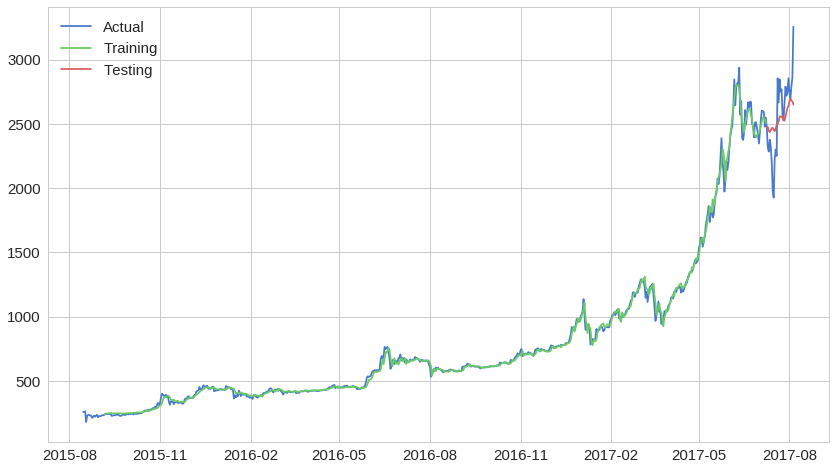

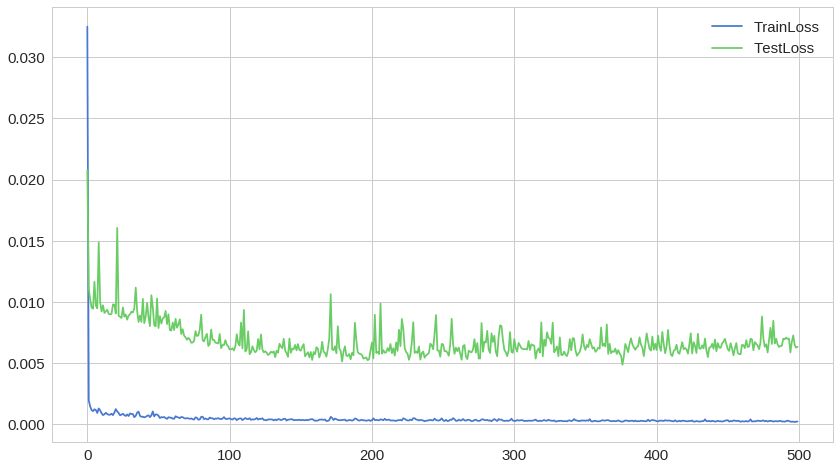

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:158: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



In [28]:
USDT_BTC = nextDayPrediction('USDT_BTC', 'poloniex' ) 

START FIT MODEL...
Learning time:  392.55524492263794
            predictionPrice
2017-08-06        45.935116
Train Score: 0.91 RMSE
Test Score: 2.70 RMSE
income ACTUAL: 
20.53584622
income PREDICTED: 
2.12527349
% TRUE predicted labels for TREND:
0.75


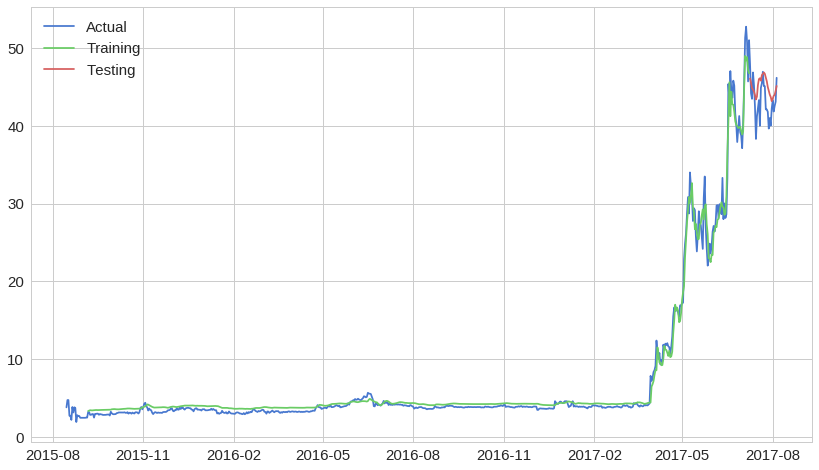

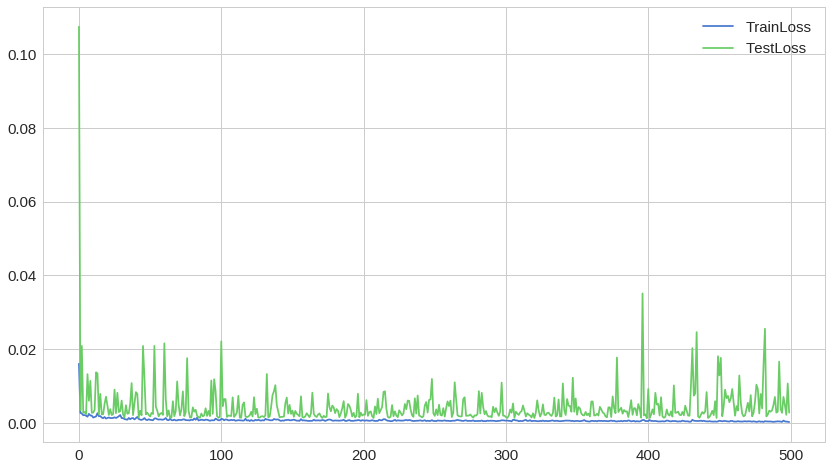

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:158: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



START FIT MODEL...
Learning time:  393.81220602989197
            predictionPrice
2017-08-06       249.253067
Train Score: 4.58 RMSE
Test Score: 45.62 RMSE
income ACTUAL: 
208.49150307
income PREDICTED: 
-121.28481527
% TRUE predicted labels for TREND:
0.392857142857


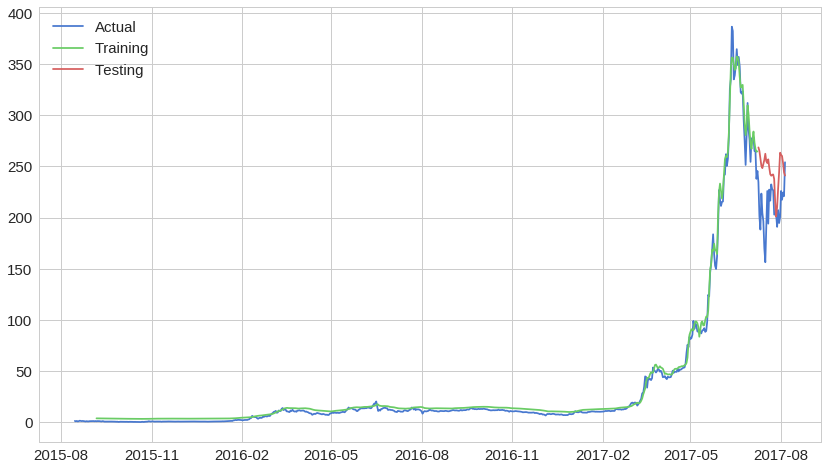

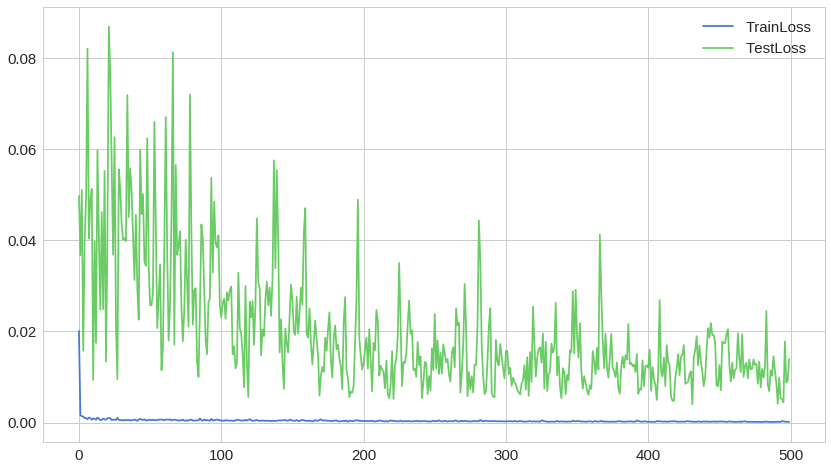

START FIT MODEL...
Learning time:  209.16555762290955
            predictionPrice
2017-08-06        16.602299
Train Score: 0.49 RMSE
Test Score: 2.37 RMSE
income ACTUAL: 
2.88002612
income PREDICTED: 
-2.03961647
% TRUE predicted labels for TREND:
0.428571428571


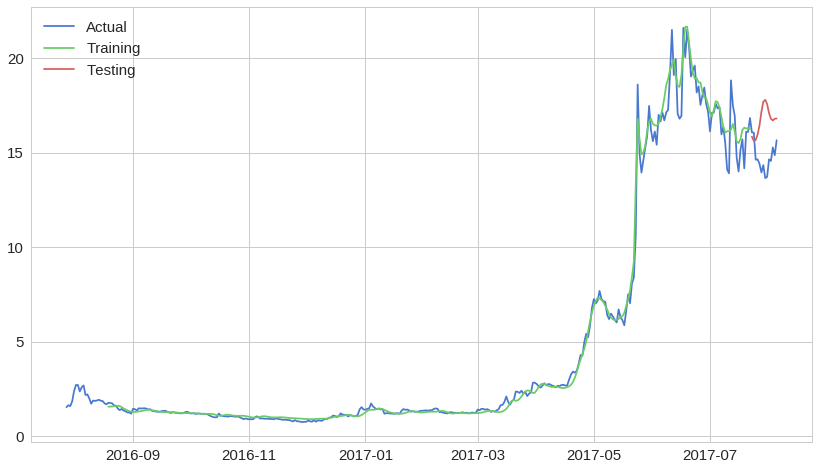

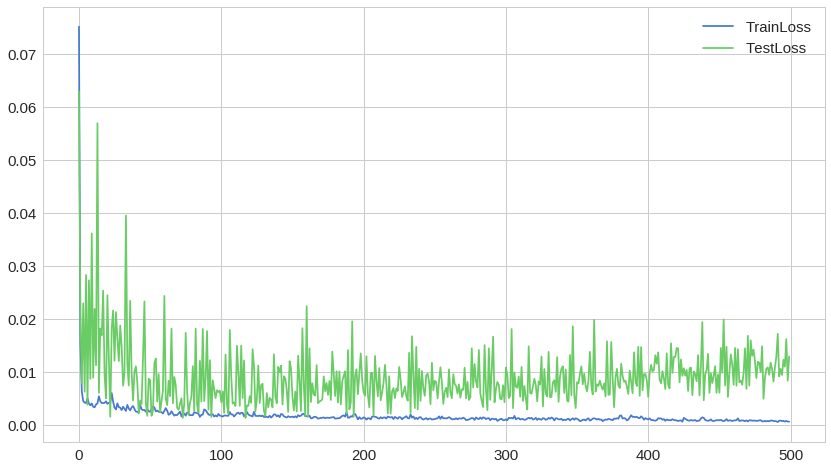

START FIT MODEL...
Learning time:  393.34120321273804
            predictionPrice
2017-08-06         0.248813
Train Score: 0.00 RMSE
Test Score: 0.07 RMSE
income ACTUAL: 
0.09319594
income PREDICTED: 
-0.01942653
% TRUE predicted labels for TREND:
0.607142857143


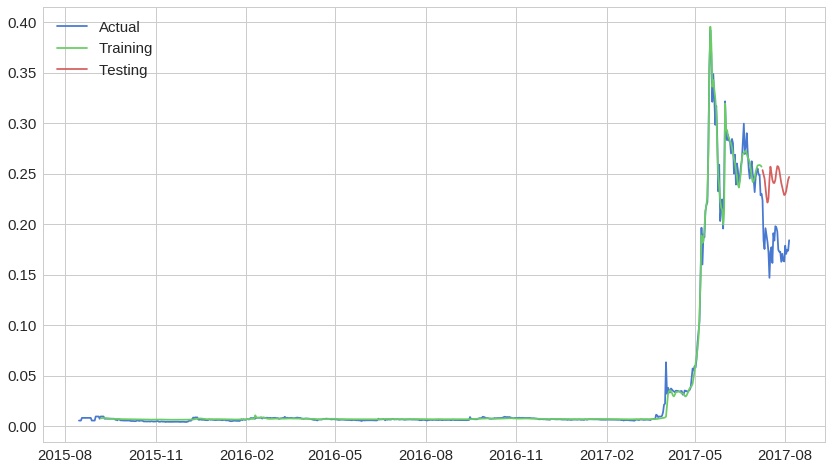

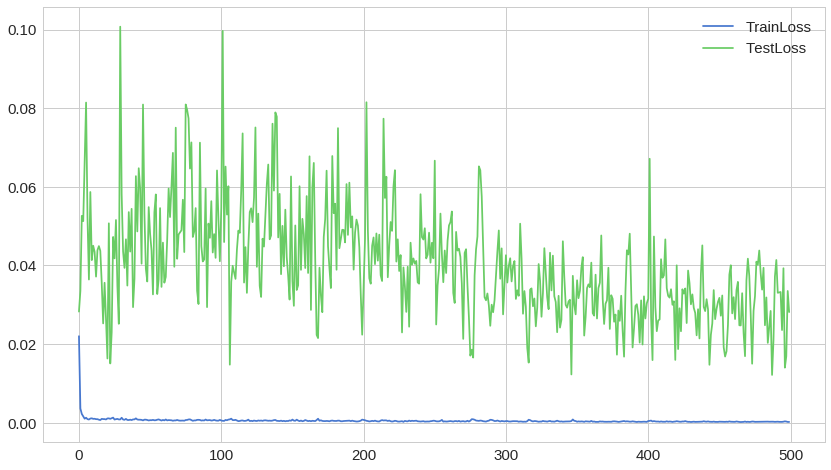

In [29]:
USDT_LTC = nextDayPrediction('USDT_LTC', 'poloniex')
USDT_ETH = nextDayPrediction('USDT_ETH', 'poloniex')

USDT_ETC = nextDayPrediction('USDT_ETC', 'poloniex')
USDT_XRP = nextDayPrediction('USDT_XRP', 'poloniex')

## Проверка гипотезы по поправочному весовому коэффициенту


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



ActualData
 [ 2557.28305108  2530.52203406  2536.77220019  2515.55304633  2449.03536422
  2394.02208393  2387.98972261  2367.74886242  2313.801675    2201.70111667
  2109.76741107  2147.64596818  2198.43064531  2215.62043011  2428.74695341
  2508.06431215  2621.04287477  2664.505528    2699.45823078  2654.97215368
  2612.09831803  2631.39887802  2684.25965202  2695.83976802  2714.89317868
  2761.59545246  2753.22452993  2735.14968662]
Difference
 [  76.21029718   34.95465124   43.37913378   29.89191351  -33.37210648
  -64.14588482  -37.77639067  -36.70890126  -84.68172344 -181.11138333
 -240.23918072 -155.17019393  -87.32350508  -88.68474567   98.10022489
  117.97935122  164.92251344  156.40347721  159.4733675    94.96873571
   61.66057389  102.70527451  157.53846061  144.08244381  142.52843259
  174.88842121  137.7213561    97.23855381]
ErrorInPercent:
 [  2.98012757   1.38132175   1.71001298   1.18828397  -1.36266332
  -2.67941909  -1.58193272  -1.5503714   -3.65985228  -8.225975
 -1

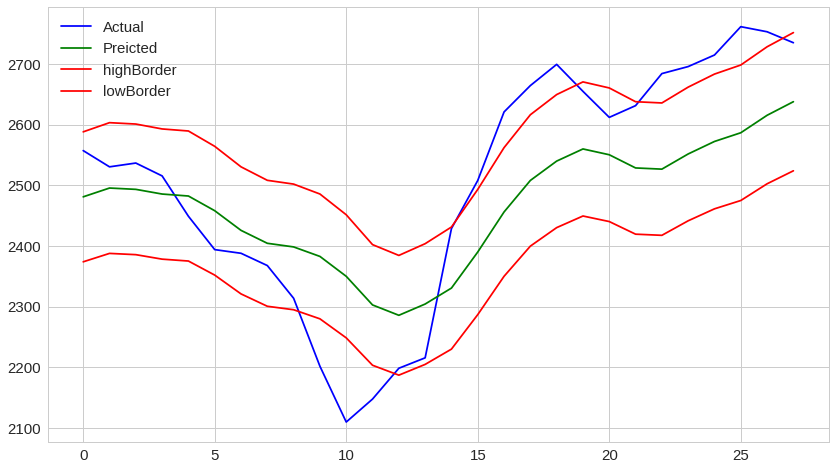

In [7]:
ActualData = np.array(pd.ewma(get_data.get_data_frame().close, 2))[-np.array(Testing.dropna()).shape[0]:]

# Проерка гипотезы поправочного весового коэффициента
TestingGraph = np.array(Testing.dropna())

print ('ActualData\n',ActualData)
Difference = ActualData - TestingGraph

print ('Difference\n',Difference)

ErrorInPercent = (Difference * 100 / ActualData)
MeanError = np.mean(np.abs(ErrorInPercent))

print('ErrorInPercent:\n', ErrorInPercent)
print('MeanError:\n', MeanError)

NewTestingOne = TestingGraph*(100+MeanError)/100
NewTestingTwo = TestingGraph*(100-MeanError)/100

plt.plot(ActualData, label = 'Actual', color = 'blue')
plt.plot(TestingGraph, label = 'Predicted', color = 'green')
plt.plot((NewTestingOne), label = 'highBorder', color = 'red')
plt.plot((NewTestingTwo), label = 'lowBorder', color = 'red')
plt.legend()
plt.show()